# 28-02-2024: De flow duidelijk krijgen van accuracy naar AUC naar DCA
Ik heb nu de intiutie wel scherp dat DCA goed is, maar voor de blogpost wil ik een duidelijk opbouw kiezen:

- Laat accuracy zien, leg uit waarom dit niet goed is
- Laat AUC zien, laat zien dat dit een verbetering is tov accuracy
- Laat daarna DCA zien als beste voorbeeld. 

De code hieronder zet alle relevante modellen en data klaar.

In [45]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from helper_functions import *

df_cancer_dx = pd.read_csv('https://raw.githubusercontent.com/ddsjoberg/dca-tutorial/main/data/df_cancer_dx.csv')
df_cancer_train, df_cancer_test = train_test_split(df_cancer_dx, test_size=0.3, stratify=df_cancer_dx['cancer'])

complex_model = sm.GLM.from_formula('cancer ~ age + marker + famhistory', data=df_cancer_dx, family=sm.families.Binomial()).fit()

# Accuracy is geen goed idee

We hebben dus 4 modelopties om te kiezen wie wel of niet een biopsy moet krijgen: iedereen, niemand, mensen met een voorgeschiedenis en mensen van wie het complexe model iets vindt. Eerst kijken we naar de accuracy van deze opties. Accuracy is dan (TP+TN)/N_obs, in essesntie hoe vaak je het goede antwoord geeft. 

In [46]:
calc_metrics(input_prob = {'famhistory': df_cancer_test['famhistory'], 
                                    'complex_model': complex_model.predict(df_cancer_test)},
                      true =       df_cancer_test['cancer'],
                      metrics =    'accuracy')

,accuracy_famhistory,accuracy_complex_model,accuracy_everyone,accuracy_noone
0.5,0.786667,0.875556,0.142222,0.857778


Opvallend:

- Niemand een biopsy geven heeft een best wel hoge accuracy, terwijl iedereen een biopsy geven by far de laagste heeft. Belangrijk in deze is dat de accuracy van beide simpelweg het voorkomen van kanker in de data set geeft. `acc_ev = prev` en `acc_noone = 1 - prev`. 
- Niemand biopsy doet het ook nog beter dan een model op basis van famhistory, en het compexe model doet het maar een heel klein beetje beter. 

Wat je hier goed scherp moet hebben is dat accuracy dus gevoelig is voor onbalans in de data (6x meer niet-kanker), en dat in accruacy een TP en een TN precies even 'erg' zijn. In deze medische setting is dat zeker niet het geval: een onnodige biopsie is minder erg dan dat iemand overlijd aan een niet gevonden kanker. 

# 01-03-2024: threshold probabilities en de AUC
Voordeel AUC:
- Heeft geen last can class imbalance. 

Binaire classifiers geven de probability terug dat een observatie 1 is (doe een biopsie). Om dit om te zetten naar een echte binaire (0/1) voorspelling moet je een threshold-probability kiezen waarboven de voorspelling 1 is. Typisch wordt deze threshold als 0.5 gekozen, maar dit kan ook geoptimaliseerd worden. 

Zie bijvoorbeeld de volgende voorspelling op basis van het complexe model of iemand een biopsie moet krijgen of niet:

In [47]:
complex_model.predict(df_cancer_test).head(2)

204    0.005989
407    0.056655
dtype: float64

Deze twee observaties hebben een lage prob, dus het model zegt dat de kans laag is dat deze patient een biopsie nodig heeft. Maar voor deze test set weten we ook of deze mensen kanker hadden of niet. Voor elk van de handelingsopties maken we een nieuwe kolom aan met de waarschijnlijkheden dat een patient een biopsy nodig heeft of niet en visualiseren we deze verdeling voor het complexe model voor de mensen met én zonder kanker:

<Axes: title={'center': 'Density plot'}, ylabel='Density'>

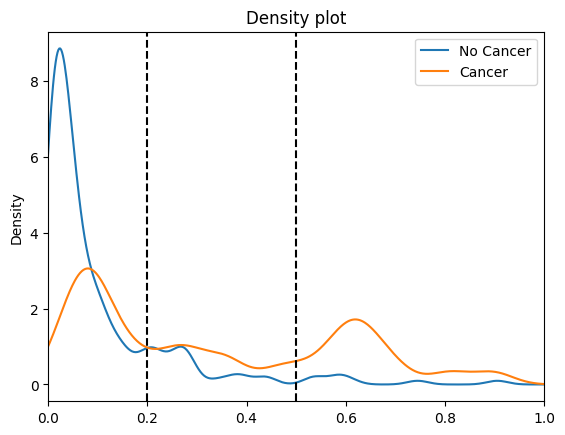

In [144]:
def prob_density_plot(df, y, by, title='Density plot', vline=[0.5, 0.2], labels=['No Cancer', 'Cancer'], bw_method=0.15):
    fig, ax = (df_cancer_test[[by, y]]
        .groupby(by)[y]
        .plot.kde(legend=True, xlim=(0,1), bw_method=bw_method, title=title))
    for v in vline:
        ax.axvline(x=v, color='black', linestyle='--')
    ax.legend(labels)
    return fig

df_cancer_test['complex_prob'] = complex_model.predict(df_cancer_test)
df_cancer_test['famhistory_prob'] = df_cancer_test['famhistory']
df_cancer_test['noone_prob'] = np.zeros(len(df_cancer_test['cancer'])) 
df_cancer_test['everyone_prob'] = np.ones(len(df_cancer_test['cancer'])) 

prob_density_plot(df_cancer_test, y='complex_prob', by='cancer')

Het plot laat de volgende dingen zien:
- Meeste mensen die geen kanker hebben scoren ook laag (<= 0.3) op de waarschijnlijkheid vanuit het complexe model. 
- De verdeling voor kanker patienten is niet zo mooi, zowel hoog als laagscorende patienten hebben kanker. 

# 04-03-2024: De AUC score en roc curve
Om deze waarschijnlijkheidsscore om te zetten naar wél of niet een biopsie doen moeten we een threshold kiezen waarboven we denken dat de patient kanker heeft of niet. De volgende analyse varieert deze threshold waarde en berekent hoe vaak het model correct kanker voorspeld (true positive rate) en hoe vaak het model ten onrechte kanker voorspeld (false positive rate):

<Axes: xlabel='p'>

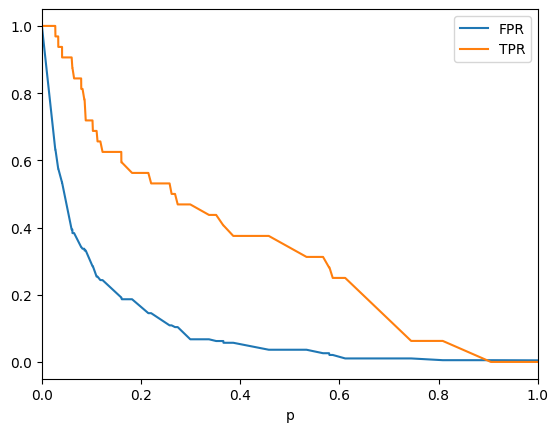

In [129]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr_tpr = pd.DataFrame(roc_curve(df_cancer_test['cancer'], df_cancer_test['complex_prob']), index=['FPR', 'TPR', 'p']).T
fpr_tpr.plot(x='p', xlim = (0,1))

Opvallend:
- Als je de threshold waarde op 0 hebt staan is je TPR 1: je voorspeld dat iedereen kanker gaat krijgen en dus een biopsie nodig heeft. Als tradeoff is the FPR ook super hoog: ook iedereen die géén kanker heeft krijgt een biopsie. 
- Aan de andere kant van het spectrum (p=0) werkt het precies de andere kant op: niemand heeft kanker waardoor je alle kanker patienten geen biopsie geeft (TPR=0), maar er zijn ook geen mensen die ten onrechte een biopsie krijgen. 

Ergens tussen deze twee extremen ligt een ideale tussenweg. Een mooie visualisatie is om de TPR en FPR tegen elkaar uit te zetten:

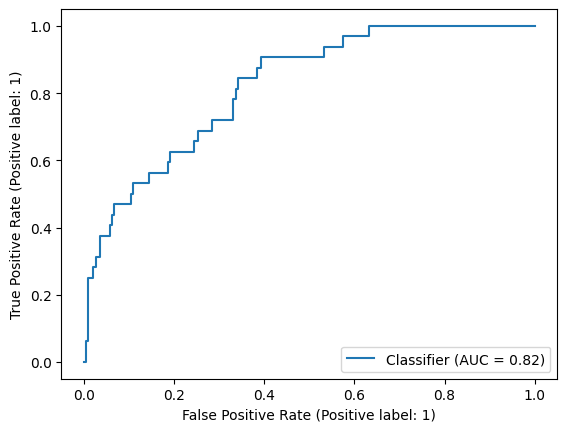

In [130]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_true = df_cancer_test['cancer'], y_pred = df_cancer_test['complex_prob'])

dit plot is het klassieke ROC curve plot. De oppervlakte onder dit plot (area under curve) geeft de performance van het model over de hele range van mogelijke thresholds. De range voor de AUC is tussen de 0.5 en de 1.0. Het geeft een gevoel voor hoeveel beter het model het doet dan simpelweg een muntje opgooien (0.5). 

Het volgende figuur laat voor alle vier handelingsopties de verdeling van de probabilities en de ROC curve zien:

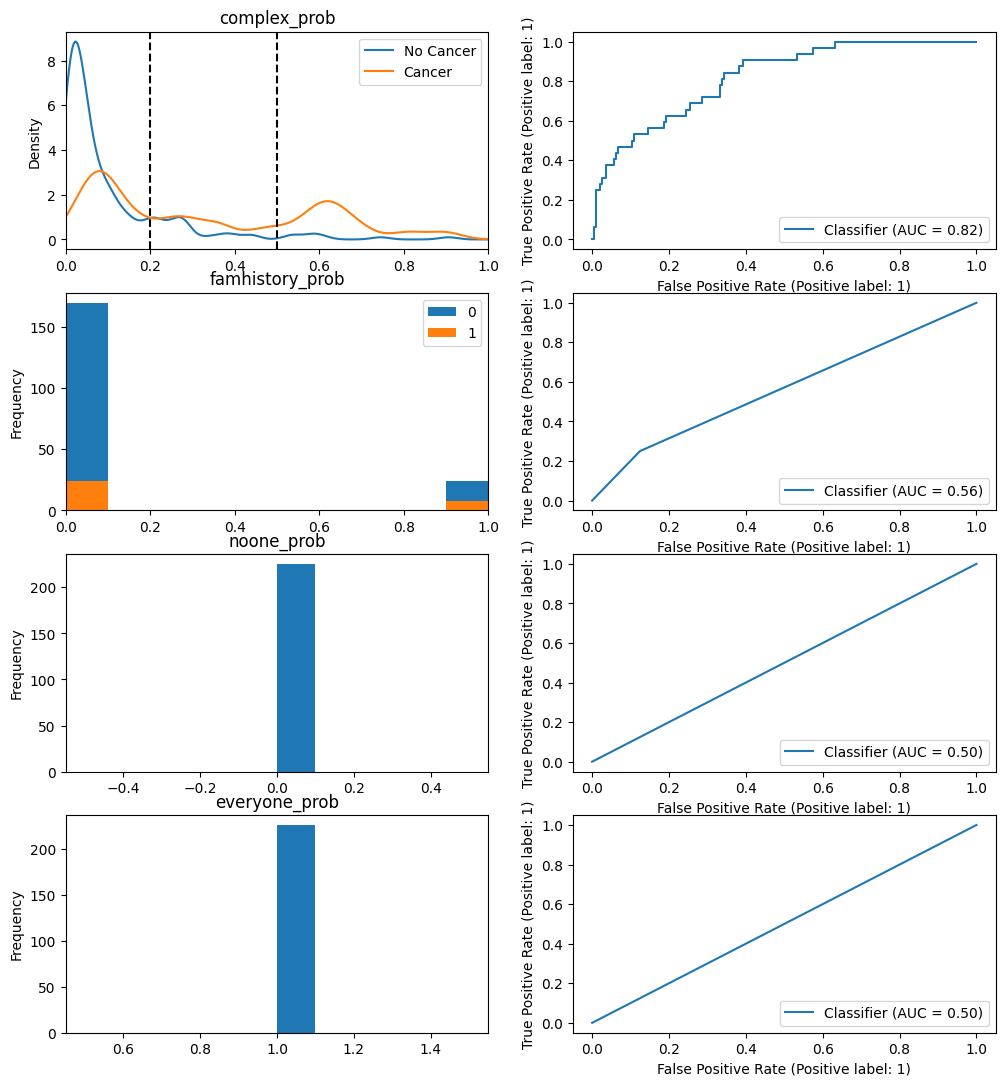

In [154]:
plt.figure(figsize=(12,13))
base_subplot = 420

for i, col in enumerate(['complex_prob', 'famhistory_prob', 'noone_prob', 'everyone_prob']):
    roc_pos_offset = (2*(i + 1))
    plt.subplot(base_subplot + roc_pos_offset - 1)
    if col == 'complex_prob':
        prob_density_plot(df_cancer_test, col, 'cancer', title=col)
    elif col == 'famhistory_prob':
        df_cancer_test.groupby('cancer')[col].plot.hist(legend=True, xlim=(0,1), title=col)
    else:
        df_cancer_test[col].plot(kind='hist', title=col)

    ax = plt.subplot(base_subplot + roc_pos_offset)
    RocCurveDisplay.from_predictions(y_true = df_cancer_test['cancer'], y_pred = df_cancer_test[col], ax=ax)

Opvallend:

- De niet-complexe handelingsopties doen het niet beter dan willekeurig kiezen welke patienten een biopsie nodig hebben. 
- Het famhistory model heeft niet een mooie gladde verdeling van probabilities: als een patient een famhistory heeft is de probablity 1, anders is deze 0. 
- Het fam_hist model heeft wel een significant effect: de fractie gezonde patienten is veel hoger bij famhistory=0 dan bij famhistory is 1. Maar er zijn kanker en niet-kanker patienten bij zowel famhis=1 als 0. Dit leidt er toe dat de AUC, ondanks het effect wat wel bestaat, leidt tot een zeer lage AUC score. 
- Het complexe model heeft verreweg de hoogste performance. Hier zijn een tweetal extra variabelen toegevoegd naast famhistory. Deze verbeteren het model significant. 
- Zowel no one als everyone hebben een simpele verdeling qua probabilities, alles 0 en alles 1 respectively. Beide leiden tot een AUC van 0.5, wat betekend dat je volgens deze metric net zo goed een muntje kan opgooien. Dit in contrast tot de accuracy, welke no one een betere score gaf dan het complexe model. 

De ROC curve en de AUC kunnen dus wel omgaan met ongeblanceerde data, en zijn daarmee een veel betere manier om te bepalen welke handelingsoptie een goed idee is of niet. 

# 05-03-2024: op naar net_benefit

De AUC score kan dus beter omgaan met 